In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch.nn as nn
from tqdm import tqdm
import os
from torchvision import transforms
import json
from PIL import Image

import sys
sys.path.append("../")

In [3]:
N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
MODEL_NEURONS = 16

In [4]:
COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}

In [5]:
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]

In [6]:
def get_norm_params(dataloader):
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}

In [ ]:
# def vector_to_heatmaps(keypoints):
#     heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])
#     for k, (x, y) in enumerate(keypoints):
#         x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
#         if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
#             heatmaps[k, int(y), int(x)] = 1

#     heatmaps = blur_heatmaps(heatmaps)
#     return heatmaps


In [8]:
def blur_heatmaps(heatmaps):
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred

In [9]:
class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


In [10]:
def show_data(dataset, n_samples=12):
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()

In [ ]:
# def show_batch_predictions(batch_data, model):
#     inputs = batch_data["image"]
#     true_keypoints = batch_data["keypoints"].numpy()
#     batch_size = true_keypoints.shape[0]
#     pred_heatmaps = model(inputs)
#     pred_heatmaps = pred_heatmaps.detach().numpy()
#     pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
#     images = batch_data["image_raw"].numpy()
#     images = np.moveaxis(images, 1, -1)

#     plt.figure(figsize=[12, 4 * batch_size])
#     for i in range(batch_size):
#         image = images[i]
#         true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
#         pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

#         plt.subplot(batch_size, 3, i * 3 + 1)
#         plt.imshow(image)
#         plt.title("Image")
#         plt.axis("off")

#         plt.subplot(batch_size, 3, i * 3 + 2)
#         plt.imshow(image)
#         for finger, params in COLORMAP.items():
#             plt.plot(
#                 true_keypoints_img[params["ids"], 0],
#                 true_keypoints_img[params["ids"], 1],
#                 params["color"],
#             )
#         plt.title("True Keypoints")
#         plt.axis("off")

#         plt.subplot(batch_size, 3, i * 3 + 3)
#         plt.imshow(image)
#         for finger, params in COLORMAP.items():
#             plt.plot(
#                 pred_keypoints_img[params["ids"], 0],
#                 pred_keypoints_img[params["ids"], 1],
#                 params["color"],
#             )
#         plt.title("Pred Keypoints")
#         plt.axis("off")
#     plt.tight_layout()

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        out = self.conv_out(conv_u3)
        return out

In [13]:
class FreiHAND(Dataset):
    def __init__(self, config, set_type="train"):
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "training/rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == "train":
            n_start = 0
            n_end = 26000
        elif set_type == "val":
            n_start = 26000
            n_end = 31000
        else:
            n_start = 31000
            n_end = len(self.anno)
            
        #n_start = 0
        #n_end = 4

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image_raw = self.image_raw_transform(image_raw)
        
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)
        keypoints = torch.from_numpy(keypoints)
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }

In [ ]:
import numpy as np
import torch


class Trainer:
    def __init__(self, model, criterion, optimizer, config, scheduler=None):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.loss = {"train": [], "val": []}
        self.epochs = config["epochs"]
        self.batches_per_epoch = config["batches_per_epoch"]
        self.batches_per_epoch_val = config["batches_per_epoch_val"]
        self.device = config["device"]
        self.scheduler = scheduler
        self.checkpoint_frequency = 100
        self.early_stopping_epochs = 10
        self.early_stopping_avg = 10
        self.early_stopping_precision = 5

    def train(self, train_dataloader, val_dataloader):
        for epoch in range(self.epochs):
            self._epoch_train(train_dataloader)
            self._epoch_eval(val_dataloader)
            print(
                "Epoch: {}/{}, Train Loss={}, Val Loss={}".format(
                    epoch + 1,
                    self.epochs,
                    np.round(self.loss["train"][-1], 10),
                    np.round(self.loss["val"][-1], 10),
                )
            )

            if self.scheduler is not None:
                self.scheduler.step(self.loss["train"][-1])

            if (epoch + 1) % self.checkpoint_frequency == 0:
                torch.save(
                    self.model.state_dict(), "model_{}".format(str(epoch + 1).zfill(3))
                )

            if epoch < self.early_stopping_avg:
                min_val_loss = np.round(np.mean(self.loss["val"]), self.early_stopping_precision)
                no_decrease_epochs = 0

            else:
                val_loss = np.round(
                    np.mean(self.loss["val"][-self.early_stopping_avg:]), 
                                    self.early_stopping_precision
                )
                if val_loss >= min_val_loss:
                    no_decrease_epochs += 1
                else:
                    min_val_loss = val_loss
                    no_decrease_epochs = 0
                    #print('New min: ', min_val_loss)

            if no_decrease_epochs > self.early_stopping_epochs:
                print("Early Stopping")
                break

        torch.save(self.model.state_dict(), "model_final")
        return self.model

    def _epoch_train(self, dataloader):
        self.model.train()
        running_loss = []

        for i, data in enumerate(dataloader, 0):
            inputs = data["image"].to(self.device)
            labels = data["heatmaps"].to(self.device)

            self.optimizer.zero_grad()
            running_loss = []

            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss.append(loss.item())

            if i == self.batches_per_epoch:
                epoch_loss = np.mean(running_loss)
                self.loss["train"].append(epoch_loss)
                break

    def _epoch_eval(self, dataloader):
        self.model.eval()
        running_loss = []

        with torch.no_grad():
            for i, data in enumerate(dataloader, 0):
                inputs = data["image"].to(self.device)
                labels = data["heatmaps"].to(self.device)

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss.append(loss.item())

                if i == self.batches_per_epoch_val:
                    epoch_loss = np.mean(running_loss)
                    self.loss["val"].append(epoch_loss)
                    break

### Train Parameters

In [15]:
config = {
    "data_dir": "/kaggle/input",
    "epochs": 1000,
    "batch_size": 128,
    "batches_per_epoch": 50,
    "batches_per_epoch_val": 20,
    "learning_rate": 0.1,
    "device": torch.device("cuda:1" if torch.cuda.is_available() else "cpu"),
}

## Data

In [16]:
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset, config["batch_size"], shuffle=True, drop_last=True, num_workers=2
)

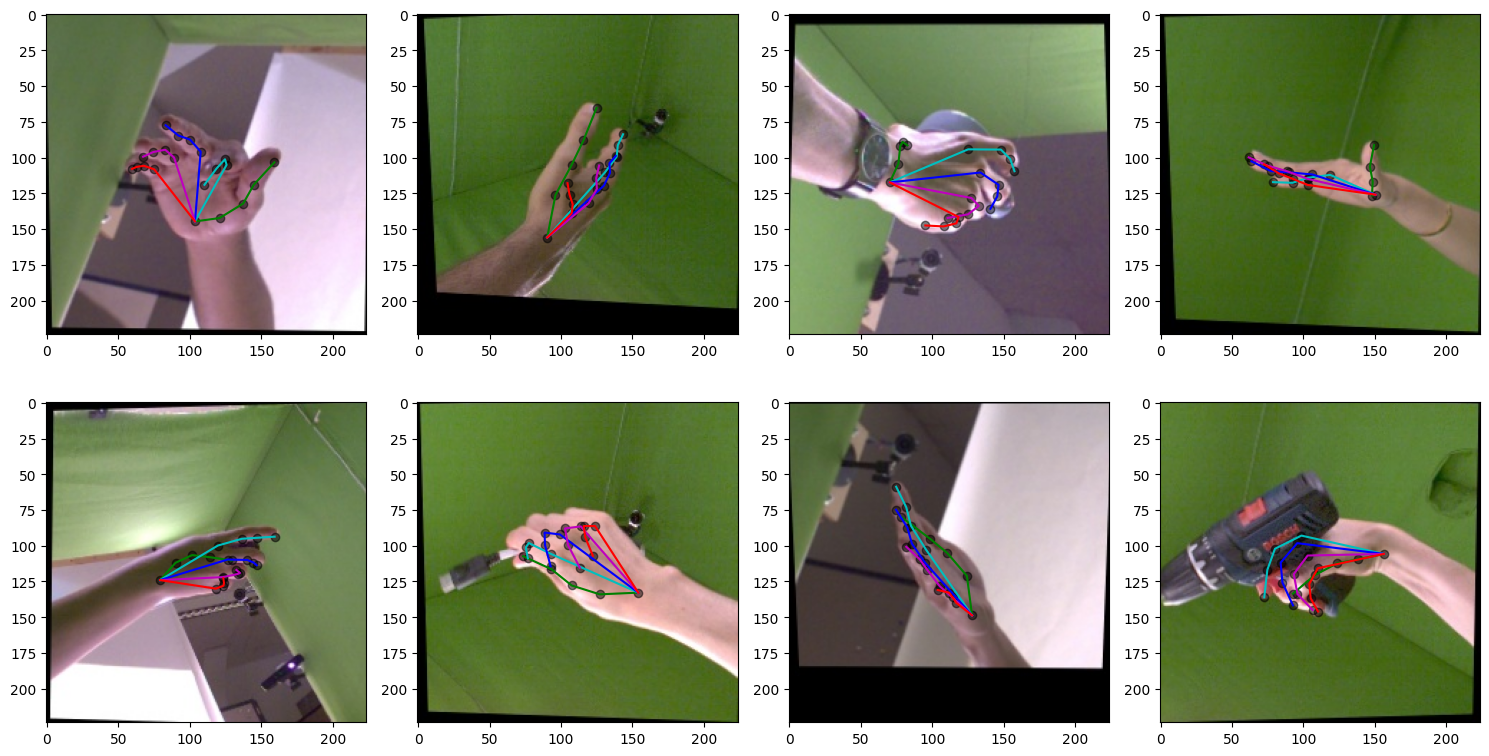

In [17]:
show_data(train_dataset, n_samples=8)

## Model

In [18]:
model = ShallowUNet(N_IMG_CHANNELS, N_KEYPOINTS)
model = model.to(config["device"])

criterion = IoULoss()
optimizer = optim.SGD(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor=0.5, patience=20, verbose=True, threshold=0.00001
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [19]:
trainer = Trainer(model, criterion, optimizer, config, scheduler)
model = trainer.train(train_dataloader, val_dataloader)

Epoch: 1/1000, Train Loss=0.9927028418, Val Loss=0.9926616918
Epoch: 2/1000, Train Loss=0.9924688339, Val Loss=0.9924509241
Epoch: 3/1000, Train Loss=0.9921783209, Val Loss=0.9921658664
Epoch: 4/1000, Train Loss=0.9918120503, Val Loss=0.9917634499
Epoch: 5/1000, Train Loss=0.9912452698, Val Loss=0.9912359629
Epoch: 6/1000, Train Loss=0.9904412627, Val Loss=0.99018624
Epoch: 7/1000, Train Loss=0.9890985489, Val Loss=0.9890680256
Epoch: 8/1000, Train Loss=0.9867529273, Val Loss=0.9869150434
Epoch: 9/1000, Train Loss=0.9832633734, Val Loss=0.9834292389
Epoch: 10/1000, Train Loss=0.9693336487, Val Loss=0.9717016192
Epoch: 11/1000, Train Loss=0.9407995343, Val Loss=0.9385292331
Epoch: 12/1000, Train Loss=0.9173551798, Val Loss=0.9222238121
Epoch: 13/1000, Train Loss=0.9245761633, Val Loss=0.9097569244
Epoch: 14/1000, Train Loss=0.9035958648, Val Loss=0.8982723668
Epoch: 15/1000, Train Loss=0.8973822594, Val Loss=0.8905422177
Epoch: 16/1000, Train Loss=0.8588525653, Val Loss=0.8674450999
Epo

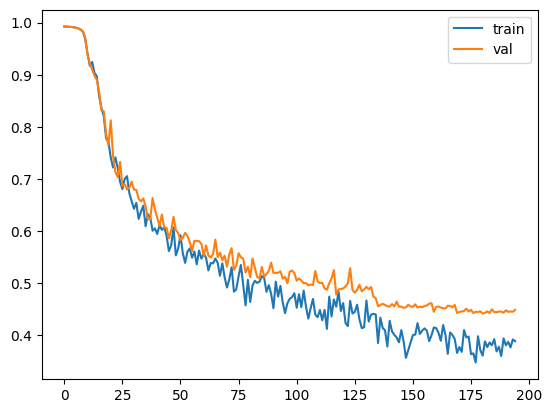

In [20]:
plt.plot(trainer.loss["train"], label="train")
plt.plot(trainer.loss["val"], label="val")
plt.legend()
plt.show()

In [24]:
torch.save(model.state_dict(), 'unet_hand_kp.pt')